# 音樂曲風分類
### 程式源自: https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-2.html

## 載入相關套件

In [1]:
# 載入相關套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')

## 載入檔案

In [25]:
# 載入音樂檔案
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

X = None
y = []
for i, g in enumerate(genres):
    pathlib.Path(f'./GTZAN/genres//{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./GTZAN/genres/{g}'):
        songname = f'./GTZAN/genres/{g}/{filename}'
        data, sr = librosa.load(songname, mono=True, duration=25)
        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
        # print(data.shape, mfcc.shape)
        if X is None:
            X = mfcc.reshape(1, 40, -1, 1)
        else:
            X = np.concatenate((X, mfcc.reshape(1, 40, -1, 1)), axis=0)
        y.append(i)
        
print(X.shape, len(y))

(1000, 40, 1077, 1) 1000


In [29]:
X[0]

array([[[-211.48465   ],
        [-208.94481   ],
        [-193.90889   ],
        ...,
        [-153.68745   ],
        [-114.75746   ],
        [ -92.81227   ]],

       [[  99.022964  ],
        [ 101.24678   ],
        [ 102.24396   ],
        ...,
        [  94.26633   ],
        [  73.02428   ],
        [  62.57588   ]],

       [[ -10.634697  ],
        [  -9.346699  ],
        [   1.9154348 ],
        ...,
        [   9.260414  ],
        [  19.25284   ],
        [  12.586103  ]],

       ...,

       [[   7.1240273 ],
        [   3.1041088 ],
        [  -3.0628586 ],
        ...,
        [  -3.839465  ],
        [  -3.0830624 ],
        [   0.40250283]],

       [[  -1.8689755 ],
        [  -1.3740795 ],
        [  -4.71682   ],
        ...,
        [  -2.7694275 ],
        [  -3.720017  ],
        [  -7.677967  ]],

       [[   4.0560246 ],
        [   2.3471432 ],
        [  -1.6581439 ],
        ...,
        [   1.7598417 ],
        [   0.9894233 ],
        [  -4.795616  ]]

In [35]:
X.min(axis=0).shape

(40, 1077, 1)

In [36]:
# 常態化
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [37]:
# 資料切割
from sklearn.model_selection import train_test_split
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.2)
X_train.shape, X_test.shape

((800, 40, 1077, 1), (200, 40, 1077, 1))

In [45]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

In [43]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

In [46]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型訓練
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# 評分(Score Model)
score=model.evaluate(X_test, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

Epoch 1/20
20/20 [==============================] - 2s 87ms/step - loss: 2.8207 - accuracy: 0.1217 - val_loss: 2.2746 - val_accuracy: 0.1813
Epoch 2/20
20/20 [==============================] - 2s 79ms/step - loss: 2.2356 - accuracy: 0.2121 - val_loss: 2.1707 - val_accuracy: 0.2000
Epoch 3/20
20/20 [==============================] - 2s 79ms/step - loss: 2.0159 - accuracy: 0.3565 - val_loss: 1.9702 - val_accuracy: 0.2313
Epoch 4/20
20/20 [==============================] - 2s 79ms/step - loss: 1.6560 - accuracy: 0.4448 - val_loss: 1.7706 - val_accuracy: 0.3562
Epoch 5/20
20/20 [==============================] - 2s 79ms/step - loss: 1.3787 - accuracy: 0.5731 - val_loss: 1.7377 - val_accuracy: 0.3625
Epoch 6/20
20/20 [==============================] - 2s 79ms/step - loss: 1.1295 - accuracy: 0.6587 - val_loss: 1.4760 - val_accuracy: 0.4812
Epoch 7/20
20/20 [==============================] - 2s 80ms/step - loss: 0.8118 - accuracy: 0.7710 - val_loss: 1.5183 - val_accuracy: 0.4812
Epoch 8/20
20

## 準確率繪圖

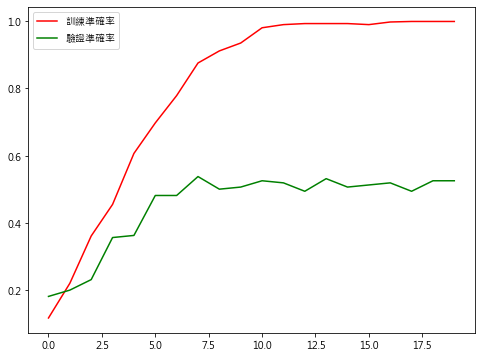

In [48]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.legend()

## 訓練準確率高達99.89%，而驗證準確率只有52.50%，表示模型有過度擬合(Overfitting)的現象。

## 載入檔案

In [56]:
# 載入音樂檔案
X = None
y = []
for i, g in enumerate(genres):
    pathlib.Path(f'./GTZAN/genres//{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'./GTZAN/genres/{g}'):
        songname = f'./GTZAN/genres/{g}/{filename}'
        data, sr = librosa.load(songname, mono=True, duration=25)
        try:
            if i == 0:
                segment_length = int(data.shape[0] / 10)
            for j in range(10):
                segment = data[j * segment_length: (j+1) * segment_length]
                # print(segment.shape)
                mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=40)
                # print(data.shape, mfcc.shape)
                if X is None:
                    X = mfcc.reshape(1, 40, -1, 1)
                else:
                    X = np.concatenate((X, mfcc.reshape(1, 40, -1, 1)), axis=0)
                y.append(i)
        except:
            print(i)
            raise Exception('')
print(X.shape, len(y))

(10000, 40, 108, 1) 10000


In [57]:
# 常態化
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [58]:
# 資料切割
from sklearn.model_selection import train_test_split
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.2)
X_train.shape, X_test.shape

((8000, 40, 108, 1), (2000, 40, 108, 1))

In [59]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

In [60]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型訓練
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# 評分(Score Model)
score=model.evaluate(X_test, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

Epoch 1/20
200/200 [==============================] - 3s 11ms/step - loss: 2.1546 - accuracy: 0.2051 - val_loss: 1.4888 - val_accuracy: 0.4625
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 1.3956 - accuracy: 0.4923 - val_loss: 1.3146 - val_accuracy: 0.5213
Epoch 3/20
200/200 [==============================] - 2s 11ms/step - loss: 1.1774 - accuracy: 0.5892 - val_loss: 1.1335 - val_accuracy: 0.6237
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 1.0417 - accuracy: 0.6318 - val_loss: 1.1006 - val_accuracy: 0.6269
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 0.9482 - accuracy: 0.6796 - val_loss: 1.0217 - val_accuracy: 0.6506
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 0.8718 - accuracy: 0.6868 - val_loss: 1.0088 - val_accuracy: 0.6550
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 0.8039 - accuracy: 0.7179 - val_loss: 0.9686 - val_accuracy: 0.6762

## 準確率繪圖

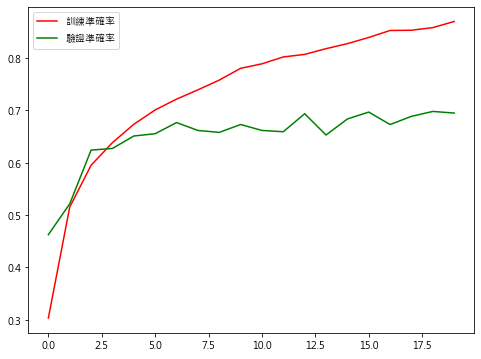

In [61]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.legend()